# Eurovision 2022 (Draft Notebook)

## Plan

### 1. Pre-Analysis or Exploratory Data Analysis

Worth doing again, with newer data.

1. Basically, redo figure 7 from the paper with the newest data

## 2. Agent-Based Models

1. Null Model
2. Model 1
3. Cultural Affinity Model
   a. Cultural Affinity Model part 2


## 3. Find Best Fit

1. Kolmogorov-Smirnov test
2. Hypothesis: Simulated and Empirical FoF come from the same distribution.
    3. This was rejected in the original paper
    
    
### Further Work
1. Consider doing section 5
2. Ambitious: Section 6


Suggestion: Focus on the ABMs as opposed to fully recreating the full paper (K-S tests etc.) 
Also try various things:  subsets of networks.  what happens if you take away a node etc etc.  Give extra weight to Ukraine itself?

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import networkx as nx
import matplotlib.pyplot as plt
from mesa import Model, Agent
from mesa.time import RandomActivation
import pyvis.network as pyvisnetwork
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector


from scipy.stats import rankdata

# 1. Exploratory Data Analysis

First, we load the data for the various years and then visualize the network for a given year

In [2]:
#df = pd.read_excel('https://query.data.world/s/cuokq5sbbqlogvjrdwdeacvp367xnq')
df = pd.read_csv("data/dataworld.csv")
df

,Unnamed: 0.1,Unnamed: 0,Year,(semi-) final,Edition,Jury or Televoting,From country,To country,Points,Duplicate
0,0,0,1975,f,1975f,J,Belgium,Belgium,0,x
1,1,1,1975,f,1975f,J,Belgium,Finland,0,NaN
2,2,2,1975,f,1975f,J,Belgium,France,2,NaN
3,3,3,1975,f,1975f,J,Belgium,Germany,0,NaN
4,4,4,1975,f,1975f,J,Belgium,Ireland,12,NaN
...,...,...,...,...,...,...,...,...,...,...
56307,56307,56307,2022,f,2022f,T,United Kingdom,Serbia,1,NaN
56308,56308,56308,2022,f,2022f,T,United Kingdom,Spain,5,NaN
56309,56309,56309,2022,f,2022f,T,United Kingdom,Sweden,4,NaN
56310,56310,56310,2022,f,2022f,T,United Kingdom,Switzerland,0,NaN


In [3]:
df.rename(columns=lambda x: x.strip(), inplace=True)
df.rename(columns={
    "(semi-) final": "semi_or_final",
    "Jury or Televoting": "jury_or_televoting",
    "From country": "from",
    "To country": "to",
    "Points": "points"
}, inplace=True)

In [26]:
df_finals = df[df["semi_or_final"] == 'f']
df_finals_televoting = df_finals[df_finals["jury_or_televoting"] == "T"]
df_finals_jury = df_finals[df_finals["jury_or_televoting"] == "J"]

display(df_finals_televoting)
display(df_finals_jury)

,Unnamed: 0.1,Unnamed: 0,Year,semi_or_final,Edition,jury_or_televoting,from,to,points,Duplicate
36352,36352,36352,2016,f,2016f,T,Albania,Armenia,2,NaN
36353,36353,36353,2016,f,2016f,T,Albania,Australia,12,NaN
36354,36354,36354,2016,f,2016f,T,Albania,Austria,0,NaN
36355,36355,36355,2016,f,2016f,T,Albania,Azerbaijan,0,NaN
36356,36356,36356,2016,f,2016f,T,Albania,Belgium,0,NaN
...,...,...,...,...,...,...,...,...,...,...
56307,56307,56307,2022,f,2022f,T,United Kingdom,Serbia,1,NaN
56308,56308,56308,2022,f,2022f,T,United Kingdom,Spain,5,NaN
56309,56309,56309,2022,f,2022f,T,United Kingdom,Sweden,4,NaN
56310,56310,56310,2022,f,2022f,T,United Kingdom,Switzerland,0,NaN


,Unnamed: 0.1,Unnamed: 0,Year,semi_or_final,Edition,jury_or_televoting,from,to,points,Duplicate
0,0,0,1975,f,1975f,J,Belgium,Belgium,0,x
1,1,1,1975,f,1975f,J,Belgium,Finland,0,NaN
2,2,2,1975,f,1975f,J,Belgium,France,2,NaN
3,3,3,1975,f,1975f,J,Belgium,Germany,0,NaN
4,4,4,1975,f,1975f,J,Belgium,Ireland,12,NaN
...,...,...,...,...,...,...,...,...,...,...
56283,56283,56283,2022,f,2022f,J,United Kingdom,Serbia,1,NaN
56284,56284,56284,2022,f,2022f,J,United Kingdom,Spain,10,NaN
56285,56285,56285,2022,f,2022f,J,United Kingdom,Sweden,12,NaN
56286,56286,56286,2022,f,2022f,J,United Kingdom,Switzerland,2,NaN


Let's visualize!

# Network of votes

In [5]:
df_finals_televoting_2022 = df_finals_televoting[df_finals_televoting["Year"]==2022].copy()

display(df_finals_televoting_2022)

,Unnamed: 0.1,Unnamed: 0,Year,semi_or_final,Edition,jury_or_televoting,from,to,points,Duplicate
54387,54387,54387,2022,f,2022f,T,Albania,Armenia,0,NaN
54388,54388,54388,2022,f,2022f,T,Albania,Australia,0,NaN
54389,54389,54389,2022,f,2022f,T,Albania,Azerbaijan,0,NaN
54390,54390,54390,2022,f,2022f,T,Albania,Belgium,0,NaN
54391,54391,54391,2022,f,2022f,T,Albania,Czech Republic,0,NaN
...,...,...,...,...,...,...,...,...,...,...
56307,56307,56307,2022,f,2022f,T,United Kingdom,Serbia,1,NaN
56308,56308,56308,2022,f,2022f,T,United Kingdom,Spain,5,NaN
56309,56309,56309,2022,f,2022f,T,United Kingdom,Sweden,4,NaN
56310,56310,56310,2022,f,2022f,T,United Kingdom,Switzerland,0,NaN


#### A Sample of the Null Model

In [6]:
#df_finals_televoting_2022["null_model_points"] = 0
#
#voting_countries = df_finals_televoting_2022["from"].unique()
#
#for voting_country in voting_countries:
#    country_row_selector = df_finals_televoting_2022["from"] == voting_country
#
#    fit = np.random.uniform(0, 1, size=len(df_finals_televoting_2022[country_row_selector]))
#
#    points_given = 58 * (fit/sum(fit))
#    print(f"{voting_country=}, {points_given=}")
#    df_finals_televoting_2022.loc[country_row_selector, "null_model_points"] += points_given
#
#    
#display( df_finals_televoting_2022[ df_finals_televoting_2022["from"] == "Albania" ] )

#### A sample Model1

In [7]:
# TODO: Rules have changed in 2022?

#SCORES = np.array([12, 10, 8, 7, 6, 5, 4, 3, 2, 1])
#
#df_finals_televoting_2022["model1_points"] = 0
#
#voting_countries = df_finals_televoting_2022["from"].unique()
#
#for voting_country in voting_countries:
#    country_row_selector = df_finals_televoting_2022["from"] == voting_country
#
#    fit = pd.Series( np.random.uniform(0, 1, size=len(df_finals_televoting_2022[country_row_selector])) )
#    rank = fit.rank(ascending=False)
#    points_given = rank.apply(
#        lambda x: SCORES[int(x) - 1] if x <= 10 else 0
#    )
#    print(f"{rank=}, {voting_country=}, {type(points_given)=}")
#    df_finals_televoting_2022.loc[country_row_selector, "model1_points"] += points_given.to_numpy()
#
#
#df_finals_televoting_2022

#### Sample Affinity Model

In [8]:

df_finals_televoting_2022["relative_score"] = df_finals_televoting_2022["points"]/sum(df_finals_televoting_2022["points"])

NameError: name 'df_finals_televoting_2022_AT' is not defined

In [27]:
cultural_network = nx.from_pandas_edgelist(
    df_finals_televoting_2022,
    source="from",
    target="to",
    create_using=nx.DiGraph()
)



mu = 1
sigma = 0.075

dict_weight = {}
for edge in cultural_network.edges():
    sampled_weight = np.random.normal(mu, sigma)
    dict_weight[edge] = sampled_weight

#print(f"{dict_weight=}")

nx.set_edge_attributes(cultural_network, values = dict_weight, name = 'weight')

#for edge in cultural_network.edges():
#    print(f"{edge=}")
nx.get_edge_attributes(cultural_network, "weight")[('Albania', 'Armenia')]

1.1198307197796389

In [10]:
# TODO: Rules have changed in 2022?

#SCORES = np.array([12, 10, 8, 7, 6, 5, 4, 3, 2, 1])
#alpha = 0.1
#
#
#df_finals_televoting_2022_AT = df_finals_televoting_2022[df_finals_televoting_2022["from"] == "Austria"].copy()
#
#
#def affinity_fit(row):
#    '''
#        row: a dataframe row
#    '''
#    q = float(df_finals_televoting_2022["relative_score"].sample(1))
#    
#    from_country = row['from']
#    to_country = row['to']
#    
#    
#    network_part = nx.get_edge_attributes(cultural_network, "weight")[(from_country, to_country)]
#    
#    the_fit = alpha * q + network_part * (1 - alpha)
#    
#    print(f"{q=}, {from_country=}, {to_country=}, {the_fit=}")
#    return the_fit
#
#
#df_finals_televoting_2022_AT["p_vc"] = df_finals_televoting_2022_AT.apply(lambda row: affinity_fit(row), axis=1)
#
#df_finals_televoting_2022_AT

In [11]:
#weighted_edges = df_finals_televoting_2022.loc[:, ["From country","To country", "Points"]].to_records(index=False)
#voting_graph.add_weighted_edges_from(list(weighted_edges))
voting_graph = nx.from_pandas_edgelist(
    df_finals_televoting_2022,
    source="from",
    target="to",
    edge_attr=["points"],
    create_using=nx.DiGraph()
)

df_finals_televoting_2022

,Unnamed: 0.1,Unnamed: 0,Year,semi_or_final,Edition,jury_or_televoting,from,to,points,Duplicate,relative_score
54387,54387,54387,2022,f,2022f,T,Albania,Armenia,0,NaN,0.000000
54388,54388,54388,2022,f,2022f,T,Albania,Australia,0,NaN,0.000000
54389,54389,54389,2022,f,2022f,T,Albania,Azerbaijan,0,NaN,0.000000
54390,54390,54390,2022,f,2022f,T,Albania,Belgium,0,NaN,0.000000
54391,54391,54391,2022,f,2022f,T,Albania,Czech Republic,0,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
56307,56307,56307,2022,f,2022f,T,United Kingdom,Serbia,1,NaN,0.000442
56308,56308,56308,2022,f,2022f,T,United Kingdom,Spain,5,NaN,0.002210
56309,56309,56309,2022,f,2022f,T,United Kingdom,Sweden,4,NaN,0.001768
56310,56310,56310,2022,f,2022f,T,United Kingdom,Switzerland,0,NaN,0.000000


In [12]:
display(voting_graph.get_edge_data("United Kingdom", "Ukraine"))
display(voting_graph.get_edge_data("Ukraine", "United Kingdom"))

{'points': 12}

{'points': 7}

In [13]:
voting_graph.number_of_nodes()

40

In [14]:
voting_graph.number_of_edges()

975

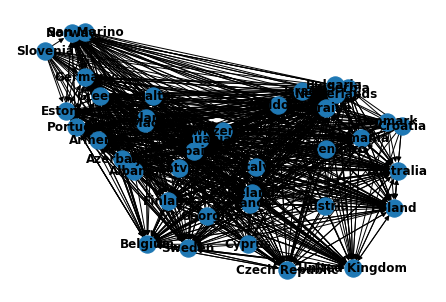

In [15]:
nx.draw_random(voting_graph, with_labels=True, font_weight='bold')

# Agent Based Modelling

## Null Model

In this null model, countries freely vote for other countries.  The only restriction is that they can assign only a fixed amount of points

In [16]:
class NullVotingAgent(Agent):
    
    def __init__(self, unique_id, model, df):
        '''
         Create a new Null Voting Agent (A "country")

         Args:
            unique_id: Unique identifier for the agent (A country name)
        '''
        
        super().__init__(unique_id, model)
        
        country_row_selector = df["from"] == unique_id

        fit = np.random.uniform(0, 1, size=len(df[country_row_selector]))

        points_given = 58 * (fit/sum(fit))
        
        #print(f"{voting_country=}, {points_given=}")
        df.loc[country_row_selector, "null_model_points"] += points_given
        
        
    def step(self):
        '''
        Run one step of the agent.
        '''
        
        pass


In [17]:
class NullVotingModel(Model):
    
    def __init__(self, df):
        '''
        Create a new NullVotingModel model.

         Args:
            df: A dataframe of votes, containing, at least, 
                * from
                * to
                * points
        '''
        
        super().__init__()

        self.df = df
        
        self.df["null_model_points"] = 0

        voting_countries = self.df["from"].unique()

        for voting_country in voting_countries:
            country_row_selector = self.df["from"] == voting_country
            a = NullVotingAgent(voting_country, self, self.df)
            

    def step(self):
        '''
        Run one step of the model. If All agents are happy, halt the model.
        '''
        
        pass

In [18]:
the_model = NullVotingModel(df_finals_televoting_2022)

df_finals_televoting_2022[df_finals_televoting_2022["from"] == "Australia"]

,Unnamed: 0.1,Unnamed: 0,Year,semi_or_final,Edition,jury_or_televoting,from,to,points,Duplicate,relative_score,null_model_points
54484,54484,54484,2022,f,2022f,T,Australia,Armenia,0,NaN,0.000000,2.579607
54485,54485,54485,2022,f,2022f,T,Australia,Azerbaijan,0,NaN,0.000000,2.572682
54486,54486,54486,2022,f,2022f,T,Australia,Belgium,0,NaN,0.000000,3.711743
54487,54487,54487,2022,f,2022f,T,Australia,Czech Republic,0,NaN,0.000000,1.878368
54488,54488,54488,2022,f,2022f,T,Australia,Estonia,0,NaN,0.000000,1.130821
54489,54489,54489,2022,f,2022f,T,Australia,Finland,0,NaN,0.000000,4.448111
54490,54490,54490,2022,f,2022f,T,Australia,France,0,NaN,0.000000,0.726906
54491,54491,54491,2022,f,2022f,T,Australia,Germany,0,NaN,0.000000,1.056704
54492,54492,54492,2022,f,2022f,T,Australia,Greece,0,NaN,0.000000,0.674734
54493,54493,54493,2022,f,2022f,T,Australia,Iceland,0,NaN,0.000000,4.057760


## Model1 ABM

In [19]:
class Model1Agent(Agent):
    
    def __init__(self, unique_id, model, df):
        '''
         Create a new Model 1 Voting Agent (A "country")

         Args:
            unique_id: Unique identifier for the agent (A country name)
        '''
        
        super().__init__(unique_id, model)
        
        
        country_row_selector = df["from"] == unique_id

        fit = pd.Series( np.random.uniform(0, 1, size=len(df[country_row_selector])) )
        rank = fit.rank(ascending=False)
        points_given = rank.apply(
            lambda x: SCORES[int(x) - 1] if x <= 10 else 0
        )
        
        #print(f"{rank=}, {voting_country=}, {type(points_given)=}")
        df.loc[country_row_selector, "model1_points"] += points_given.to_numpy()
        
        
    def step(self):
        '''
        Run one step of the agent.
        '''
        
        pass


In [20]:
class Model1Model(Model):
    
    def __init__(self, df):
        '''
        Create a new NullVotingModel model.

         Args:
            df: A dataframe of votes, containing, at least, 
                * from
                * to
                * points
        '''
        
        super().__init__()

        self.df = df
        
        self.df["model1_points"] = 0

        voting_countries = self.df["from"].unique()

        for voting_country in voting_countries:
            country_row_selector = self.df["from"] == voting_country
            a = Model1Agent(voting_country, self, self.df)
            

    def step(self):
        '''
        Run one step of the model.
        '''
        
        pass

In [21]:
SCORES = np.array([12, 10, 8, 7, 6, 5, 4, 3, 2, 1])
the_model = Model1Model(df_finals_televoting_2022)

df_finals_televoting_2022[df_finals_televoting_2022["from"] == "Australia"]

,Unnamed: 0.1,Unnamed: 0,Year,semi_or_final,Edition,jury_or_televoting,from,to,points,Duplicate,relative_score,null_model_points,model1_points
54484,54484,54484,2022,f,2022f,T,Australia,Armenia,0,NaN,0.000000,2.579607,0
54485,54485,54485,2022,f,2022f,T,Australia,Azerbaijan,0,NaN,0.000000,2.572682,0
54486,54486,54486,2022,f,2022f,T,Australia,Belgium,0,NaN,0.000000,3.711743,3
54487,54487,54487,2022,f,2022f,T,Australia,Czech Republic,0,NaN,0.000000,1.878368,5
54488,54488,54488,2022,f,2022f,T,Australia,Estonia,0,NaN,0.000000,1.130821,0
54489,54489,54489,2022,f,2022f,T,Australia,Finland,0,NaN,0.000000,4.448111,7
54490,54490,54490,2022,f,2022f,T,Australia,France,0,NaN,0.000000,0.726906,0
54491,54491,54491,2022,f,2022f,T,Australia,Germany,0,NaN,0.000000,1.056704,0
54492,54492,54492,2022,f,2022f,T,Australia,Greece,0,NaN,0.000000,0.674734,0
54493,54493,54493,2022,f,2022f,T,Australia,Iceland,0,NaN,0.000000,4.057760,12


## Affinity Model

In [22]:
class AffinityModelAgent(Agent):
    
    def __init__(self, unique_id, model, df, cultural_network):
        '''
         Create a new Model 1 Voting Agent (A "country")

         Args:
            unique_id: Unique identifier for the agent (A country name)
        '''
        
        super().__init__(unique_id, model)
        
        
        country_row_selector = df["from"] == unique_id
        
        def affinity_fit(row):
            '''
                row: a dataframe row
            '''
            q = float(df["relative_score"].sample(1))

            from_country = row['from']
            to_country = row['to']


            network_part = nx.get_edge_attributes(cultural_network, "weight")[(from_country, to_country)]

            the_fit = alpha * q + network_part * (1 - alpha)

            return the_fit

        
        country_df = df[country_row_selector]

        fit = country_df.apply(
            lambda row: affinity_fit(row), axis=1
        )
        #print(f"{unique_id=}, {fit=}")
        rank = fit.rank(ascending=False)
        points_given = rank.apply(
            lambda x: SCORES[int(x) - 1] if x <= 10 else 0
        )
        
        df.loc[country_row_selector, "affinity_model_points"] += points_given.to_numpy()
        
    def step(self):
        '''
        Run one step of the agent.
        '''
        
        pass


In [23]:
class AffinityModel(Model):
    
    def __init__(self, df, cultural_network):
        '''
        Create a new NullVotingModel model.

         Args:
            df: A dataframe of votes, containing, at least, 
                * from
                * to
                * points
        '''
        
        super().__init__()

        self.df = df
        self.df["affinity_model_points"] = 0
        
        self.cultural_network = cultural_network

        voting_countries = self.df["from"].unique()

        for voting_country in voting_countries:
            country_row_selector = self.df["from"] == voting_country
            a = AffinityModelAgent(voting_country, self, self.df, self.cultural_network)
            

    def step(self):
        '''
        Run one step of the model.
        '''
        
        pass

In [28]:
SCORES = np.array([12, 10, 8, 7, 6, 5, 4, 3, 2, 1])
alpha = 0.1
the_model = AffinityModel(df_finals_televoting_2022, cultural_network)

df_finals_televoting_2022[df_finals_televoting_2022["to"] == "Australia"]

,Unnamed: 0.1,Unnamed: 0,Year,semi_or_final,Edition,jury_or_televoting,from,to,points,Duplicate,relative_score,null_model_points,model1_points,affinity_model_points
54388,54388,54388,2022,f,2022f,T,Albania,Australia,0,NaN,0.000000,2.858481,0,1
54436,54436,54436,2022,f,2022f,T,Armenia,Australia,0,NaN,0.000000,2.581075,6,0
54534,54534,54534,2022,f,2022f,T,Austria,Australia,0,NaN,0.000000,1.217087,0,3
54583,54583,54583,2022,f,2022f,T,Azerbaijan,Australia,2,NaN,0.000884,4.215446,4,10
54631,54631,54631,2022,f,2022f,T,Belgium,Australia,0,NaN,0.000000,3.136465,3,5
54680,54680,54680,2022,f,2022f,T,Bulgaria,Australia,0,NaN,0.000000,0.980439,5,0
54730,54730,54730,2022,f,2022f,T,Croatia,Australia,0,NaN,0.000000,2.840232,0,0
54780,54780,54780,2022,f,2022f,T,Cyprus,Australia,0,NaN,0.000000,1.874577,0,8
54829,54829,54829,2022,f,2022f,T,Czech Republic,Australia,0,NaN,0.000000,1.226781,0,0
54878,54878,54878,2022,f,2022f,T,Denmark,Australia,0,NaN,0.000000,4.107627,0,0


In [49]:
def get_FoF(from_country, to_country, points_column = "points"):
    Voter_selector = df_finals_televoting_2022["from"] == from_country
    Candidate_selector = df_finals_televoting_2022["to"] == to_country

    voting_countries_2022 = df_finals_televoting_2022["from"].unique()


    N = len(voting_countries_2022)

    final_score = sum(df_finals_televoting_2022.loc[Candidate_selector, points_column])

    points = df_finals_televoting_2022.loc[Voter_selector & Candidate_selector, points_column]

    FoF =  ( points / 12 ) - ( ( final_score - points )/( 12*(N-2) ) )
    
    return FoF


print(f"{get_FoF('United Kingdom', 'Australia', 'null_model_points')=}")

get_FoF('United Kingdom', 'Australia', 'null_model_points')=56289   -0.020696
Name: null_model_points, dtype: float64


# 3. Run the ABMs in a batch for various years



# 4. Friend-Or-Foe for the ABMS

Now that we have Various models and also empirical data, we can calculate the Friend-or-Foe coefficients for each of them

# 2. Run the Agent/Model Basic

### Running the model

At this point, we have a model which runs. 
You can see for yourself with a few easy lines. If you’ve been working in an jupyter notebook session, you can create a model object directly. 

With that last piece in hand, it’s time for the first rudimentary run of the model.

Now let’s create a model with 100 agents
There is no need to run the model, since there are no steps to run.

In [22]:
model = ScaleFreeModel(100, 5)

NameError: name 'ScaleFreeModel' is not defined

# 3. Visualize the Network

Let's visualize a small Barabasi-Albert network graph with an average node degree parameter 5 (as used in the original paper - Barabási and Albert (1999)

In [23]:
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.UserParam import UserSettableParameter
from mesa.visualization.modules import ChartModule
from mesa.visualization.modules import NetworkModule
from mesa.visualization.modules import TextElement

def network_portrayal(G):
# The model ensures there is always 1 agent per node

    betweenness_centrality = dict(nx.betweenness_centrality(G))
    
    def node_color(agent, n_id):
        #return '#008000'
        return "rgba("+ str(betweenness_centrality[n_id] * 10 * 256) +",128,128,1.0)"
    
    def edge_color(agent1, agent2):
        return '#e8e8e8'
    
    def edge_width(agent1, agent2):
        return 2
    
    portrayal = dict()
    
    portrayal['nodes'] = [{'id': n_id,
                        'agent_id': n['agent'][0].unique_id,
                        'size': 2,
                        'color': node_color(n['agent'][0], n_id),
                        }
                        for n_id, n in G.nodes(data=True)]
    
    portrayal['edges'] = [{'id': i,
                        'source': source,
                        'target': target,
                        'color': edge_color(G.nodes[source]['agent'][0], G.nodes[target]['agent'][0]),
                        'width': edge_width(G.nodes[source]['agent'][0], G.nodes[target]['agent'][0]),
                        }
                        for i, (source, target, _) in enumerate(G.edges(data=True))]
    
    return portrayal

network = NetworkModule(network_portrayal, 800, 800, library='d3')
chart = ChartModule([{'Label': 'Agent', 'Color': '#008000'}])

class Density(TextElement):
    def render(self, model):
        Density = nx.density(model.G)
        return 'Density: ' + str(Density)

text = Density()

model_params = {
    'N': UserSettableParameter('slider', 'Number of agents', 10, 10, 1000, 10,
    description='Choose how many agents to include in the model'),
    'm': UserSettableParameter('slider', 'Avg Node Degree', 3, 3, 5, 1,
    description='Avg Node Degree'),
    }

server = ModularServer(ScaleFreeModel, [network, chart, text], 'Barabasi-Albert Model', model_params)

NameError: name 'ScaleFreeModel' is not defined

# 4. Run the Network Visualization

NOTE: Runtime server error is normal and expected when running visualization code below. This visualization code was made for command line execution (not explicitly for Jupyter Notebooks), so we are **forcing** it's use.

Just make sure to increment the port number counter each visualization run, to be able to use it.

In [125]:
server.port = 8524 # The default 8521 - increase the counter as you run the visalizations
server.launch() # Uncomment to run the visalization

Interface starting at http://127.0.0.1:8524


RuntimeError: This event loop is already running

Socket opened!
{"type":"reset"}
{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}
{"type":"get_step","step":21}
{"type":"get_step","step":22}
{"type":"get_step","step":23}
{"type":"get_step","step":24}
{"type":"get_step","step":25}
{"type":"get_step","step":26}
{"type":"get_step","step":27}
{"type":"get_step","step":28}
{"type":"get_step","step":29}
{"type":"get_step","step":30}
{"type":"get_step","step":31}
{"type":"get_step","step":32}
{"type":"get_step

# 5. Collect data to Analyze the Network

In [7]:
print('Number of agents {}'.format(model.G.number_of_nodes()))
print('Number of edges {}'.format(model.G.number_of_edges()))
print('Number of edges {}'.format(nx.info(model.G)))

print('Density {}'.format(nx.density(model.G)))
print('Number of selfloop edges {}'.format(nx.number_of_selfloops(model.G)))
print('Frequency of each degree value {}'.format(nx.degree_histogram(model.G))) # The degree values are the index in the list.

Number of agents 100
Number of edges 475
Number of edges Graph with 100 nodes and 475 edges
Density 0.09595959595959595
Number of selfloop edges 0
Frequency of each degree value [0, 0, 0, 0, 0, 23, 26, 11, 8, 2, 4, 2, 6, 2, 3, 2, 0, 1, 0, 2, 2, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1]


<ipython-input-7-ccf91687e3d3>:3: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print('Number of edges {}'.format(nx.info(model.G)))


# 6. Run the Agent/Model Analysis

## Question 1

1.1 Plot a graph of degrees for all nodes in the network model.

1.2 As network grows by a step (one node), explain the growth behavior that you observe on the plot?

1.3 For the last-added node, retrieve its neighbours and plot a histogram of the degrees of those neighbours.

1.4 Where and why did that new node attach itself to?

(array([ 0.,  0.,  0.,  0.,  0., 23., 26., 11.,  8.,  2.,  4.,  2.,  6.,
         2.,  3.,  2.,  0.,  1.,  0.,  2.,  2.,  0.,  1.,  0.,  0.,  1.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,

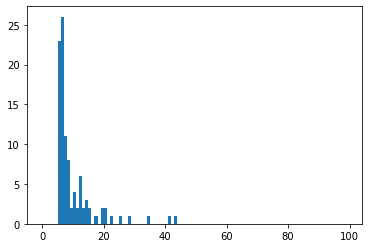

In [8]:
# Answer 1.1 [Your code here]
import matplotlib.pyplot as plt

degree_per_node = dict(model.G.degree(model.G))

plt.hist( list(degree_per_node.values()), list(degree_per_node.keys()) )

degree_per_neighbour={11: 20, 19: 19, 45: 8, 90: 6, 94: 6}


<AxesSubplot:>

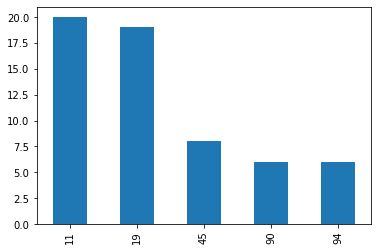

In [12]:
# Answer 1.3 [Your code here]
import pandas as pd

last_node_index = model.G.number_of_nodes() - 1
degree_per_neighbour = dict(model.G.degree(list(nx.neighbors(model.G, last_node_index))))

degree_per_neighbour = dict(sorted(degree_per_neighbour.items()))
print(f"{degree_per_neighbour=}")


data = pd.Series(degree_per_neighbour)

data.plot.bar()

## Answer 1.2 and 1.4

_1.2 As network grows by a step (one node), explain the growth behavior that you observe on the plot?_
Follows power law and preferntial attachment concept


_1.4 Where and why did that new node attach itself to?_
It will connect it to 5 neighbours.  It will choose nodes based on their degrees.  These happen to be early nodes with high degrees.

## Question 2

2.1 Plot the log log degree distribution for the network with 10k nodes.

2.2 Explain the graph?

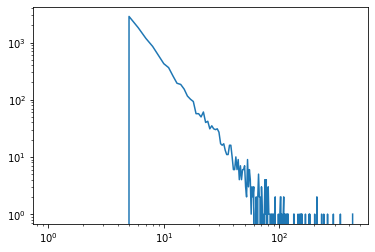

In [17]:
# Answer 2.1 [Your code here]
model_10k = ScaleFreeModel(10000, 5)

hist_10k = nx.degree_histogram(model_10k.G)

plt.loglog( range(0, len(hist_10k)), hist_10k )





## Answer 2.2

This is also following a power law.  The vast majority of nodes have a small degree.  The number of nodes with very high degrees is indeed very small and can barely be seen towards teh right of the x-axis

## Question 3

3.1 Investigate a number of degree distribution for the newtork in a few timesteps (t=10k, t=100k, t=1Million) and plot the log log degree distribution for those three networks.

3.3 Do you observe a stable degree distribution for the network regardless of its size?

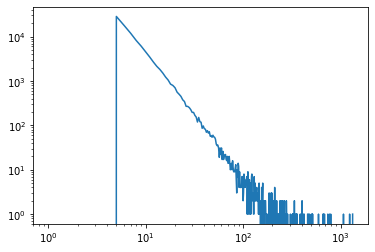

In [18]:
# Answer 3.1 [Your code here]
model_100K = ScaleFreeModel(100000, 5)

hist_100K = nx.degree_histogram(model_100K.G)
plt.loglog( range(0, len(hist_100K)), hist_100K )

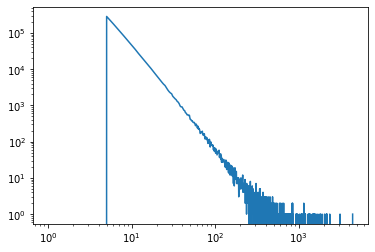

In [19]:
model_1M = ScaleFreeModel(1000000, 5)

hist_1M = nx.degree_histogram(model_1M.G)
plt.loglog( range(0, len(hist_1M)), hist_1M )

## Answer 3.3

Yes, whether the network is 10K, 100K or 1M nodes, we always see this powerlaw based degree distribution.  This makes this a "scale-free network"

# References


Spijkervet/eurovision-dataset

@misc{spijkervet_eurovision,
    author       = {Janne Spijkervet},
    title        = {{The Eurovision Dataset}},
    month        = mar,
    year         = 2020,
    doi          = {10.5281/zenodo.4036457},
    version      = {1.0},
    publisher    = {Zenodo},
    url          = {https://zenodo.org/badge/latestdoi/214236225}
}